### Download Latest Version of TensorFlow and Tensorflow Addons

In [1]:
#!pip install tensorflow==2.2.0rc2
!pip install tensorflow-addons==0.9.1
!pip install -q efficientnet --upgrade

     |████████████████████████████████| 1.0 MB 7.7 MB/s 


### Importing Dependencies

In [2]:
import re, os, gc
import sys, time
import math
import pprint
gc.enable()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import (train_test_split, 
                                     KFold, 
                                     StratifiedKFold)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
import efficientnet.tfkeras as efn

from kaggle_datasets import KaggleDatasets

### TF - Code Adjustments

In [3]:
# Check API version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 2.1.0
Keras version: 2.2.4-tf


In [4]:
print(f"TensorFlow is executing eagerly: {tf.executing_eagerly()}")
print("No of physical devices available: {}".format(len(tf.config.experimental.list_physical_devices())))
if not len(tf.config.experimental.list_physical_devices()) == 0:
    print("GPU is available." if tf.test.is_gpu_available() else "TPU is available.")

TensorFlow is executing eagerly: True
No of physical devices available: 2
TPU is available.


In [5]:
print(f"Initializing radom seeds ..")
tf.random.set_seed(2020)

print(f"Enabling TensorFlow Device Debugger ..")
tf.config.set_soft_device_placement(False)
tf.debugging.set_log_device_placement(False)

%reload_ext tensorboard

print("Done.")

Initializing radom seeds ..
Enabling TensorFlow Device Debugger ..
Done.


### Flags for TPU, XLA Compiler & Mixed Precision

#### TPU

In [6]:
if 'XRT_TPU_CONFIG' not in os.environ and "TPU_NAME" not in os.environ:
    print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
    tpu_address = os.environ['TPU_NAME']
    print('TPU address is: ', tpu_address)
    print('TPU Configuration: ',os.environ['XRT_TPU_CONFIG'])
    with tf.compat.v1.Session(tpu_address) as session:
        devices = session.list_devices()
    print('TPU devices:')
    pprint.pprint(devices)

TPU address is:  grpc://10.0.0.2:8470
TPU Configuration:  tpu_worker;0;10.0.0.2:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 7008097608958012106),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 12746716119685629079),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11945454442514666772),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 8310722591225629352),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3091959682897569547),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 3251547493107868699),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 17253027386088302626),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 13230662421056018876),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0

In [7]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
elif len(gpus) > 1: # multiple GPUs in one VM
    strategy = tf.distribute.MirroredStrategy(gpus)
else: # default strategy that works on CPU and single GPU
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.0.0.2:8470']
REPLICAS:  8


#### XLA Compiler

In [8]:
# This ensures that XLA and ptxas work well together, and helps with scaling.
print('Configuring XLA ..')
if os.getenv("XLA_FLAGS") is None:
    print('XLA not found.')
    tf.config.optimizer.set_jit(False) # Make XLA disabled.
else:
    print("XLA_FLAGS='{}'".format(os.getenv("XLA_FLAGS")))
    tf.config.optimizer.set_jit(True)

Configuring XLA ..
XLA not found.


#### Mixed Precision

In [9]:
tf.config.optimizer.set_jit(True)

### Model Config

In [10]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [512, 512]
EPOCHS = 25
FOLDS = 2
SEED = 2020
BATCH_SIZE = 12 * strategy.num_replicas_in_sync
AUG_BATCH = BATCH_SIZE
FIRST_FOLD_ONLY = False

### Data Config

In [11]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

GCS_PATH_SELECT = { 
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}

GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

### List of Labels 

In [12]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily',
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',          
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',         
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',     
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               

### Data Processing

Learn here: 

[TensoFlow Tutorials - Images](https://www.tensorflow.org/tutorials/load_data/images)

[TensoFlow Tutorials - TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord)

#### TF-Record to Image Preprocessing

In [13]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64), 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),  
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled = True, ordered = False):    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    return dataset

#### Transform Images to Dataset

In [14]:
def get_training_dataset(dataset, do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.batch(AUG_BATCH)
    if do_aug: 
        dataset = dataset.unbatch().map(apply_rotation, num_parallel_calls=AUTO).batch(AUG_BATCH).map(transform, num_parallel_calls=AUTO)
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(dataset, do_onehot=True):
    dataset = dataset.batch(BATCH_SIZE)
    if do_onehot: dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

#### Utitlity Functions

In [15]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label   

def onehot(image,label):
    CLASSES = 104
    return image,tf.one_hot(label,CLASSES)

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


In [16]:
NUM_TRAINING_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (FOLDS-1.)/FOLDS )
NUM_VALIDATION_IMAGES = int( count_data_items(TRAINING_FILENAMES) * (1./FOLDS) )
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = int(NUM_TRAINING_IMAGES/BATCH_SIZE)

print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 8232 training images, 8232 validation images, 7382 unlabeled test images


#### Augmentation

##### CutMix Augmentation

In [17]:
def cutmix(image, label, PROBABILITY = 1.0):
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) 
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

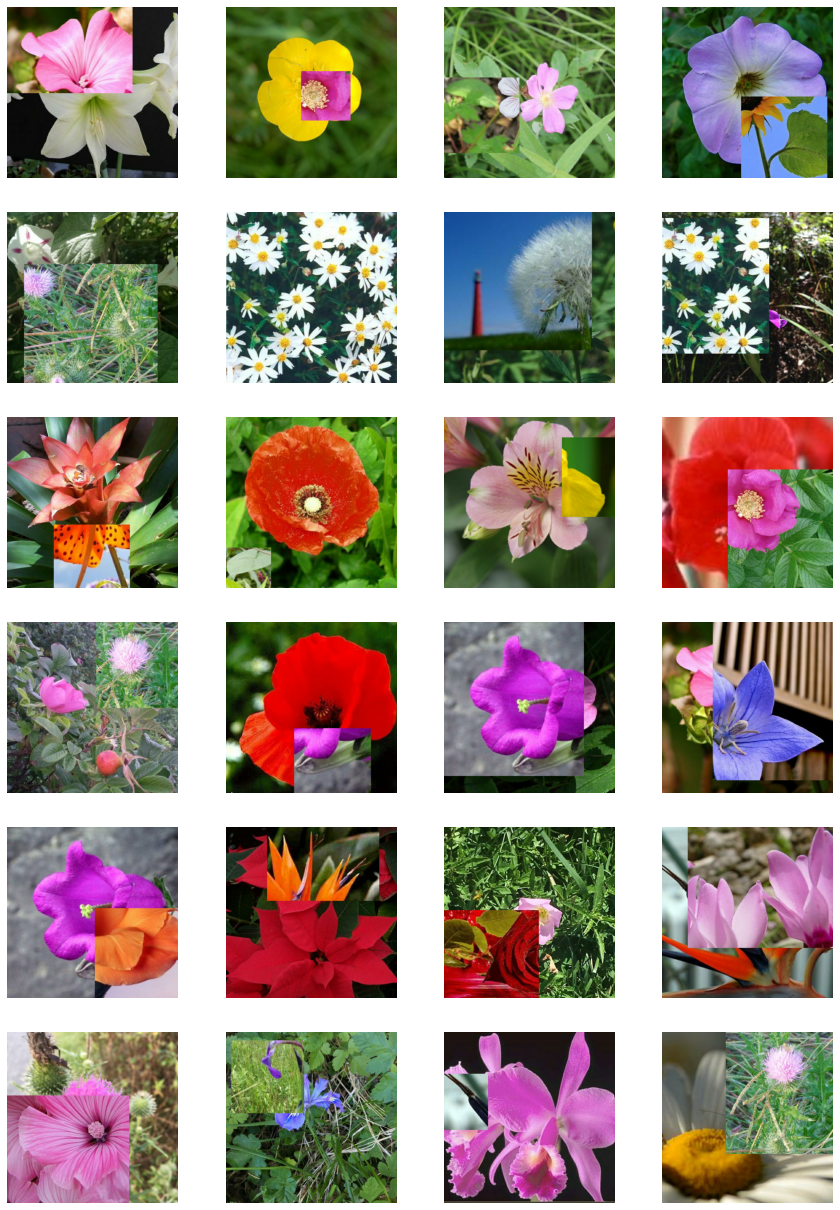

In [18]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(cutmix)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

##### Mixup Augmentation

In [19]:
def mixup(image, label, PROBABILITY = 1.0):
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
    return image2,label2

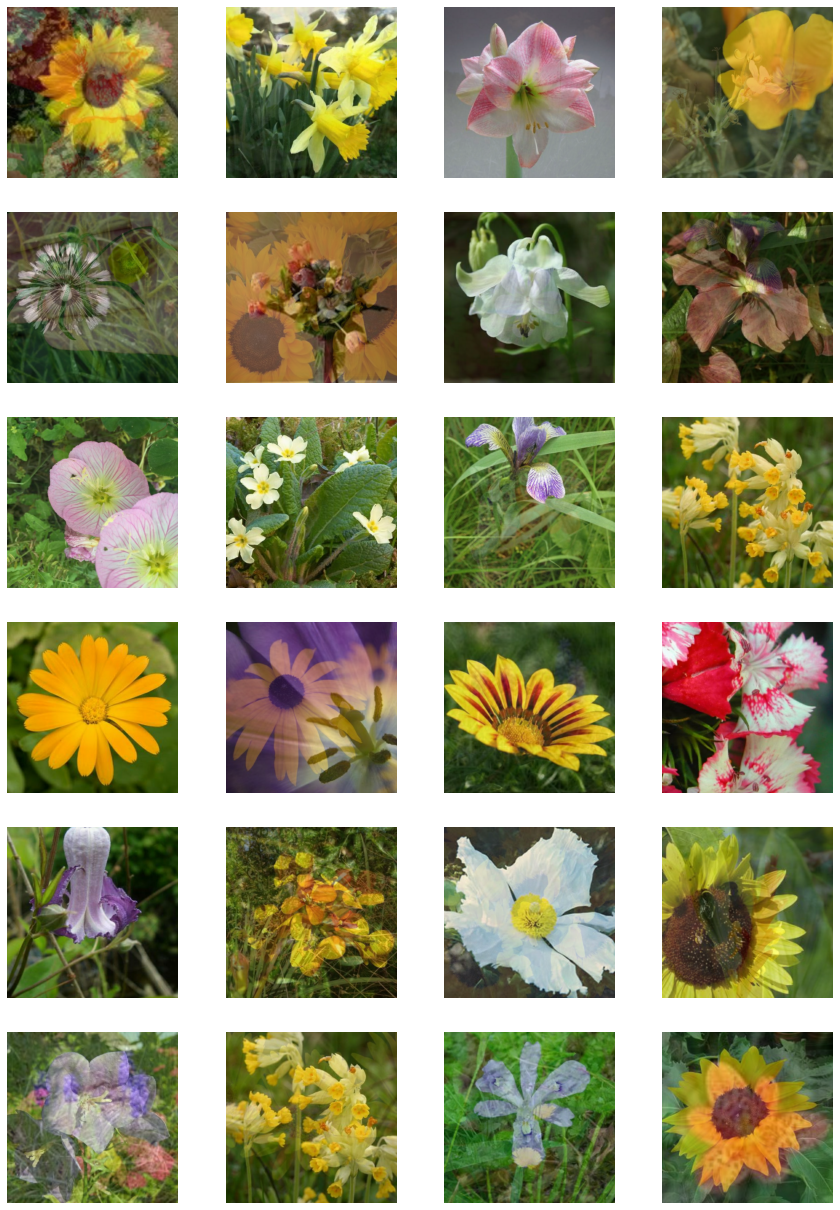

In [20]:
row = 6; col = 4;
row = min(row,AUG_BATCH//col)
all_elements = get_training_dataset(load_dataset(TRAINING_FILENAMES),do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(AUG_BATCH).map(mixup)

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

##### Rotation Augmentation

In [21]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [22]:
def apply_rotation(image,label):
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
    return tf.reshape(d,[DIM,DIM,3]),label

In [23]:
CUTMIX = True
MIXUP = True
ROTATION = True

def transform(image,label):
    DIM = IMAGE_SIZE[0]
    CLASSES = 104
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    if CUTMIX and MIXUP:
        image2, label2 = cutmix(image, label, CUTMIX_PROB)
        image3, label3 = mixup(image, label, MIXUP_PROB)
        imgs = []; labs = []
        for j in range(AUG_BATCH):
            P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
            imgs.append(P*image2[j,]+(1-P)*image3[j,])
            labs.append(P*label2[j,]+(1-P)*label3[j,])
        image4 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
        label4 = tf.reshape(tf.stack(labs),(AUG_BATCH,CLASSES))
        return image4,label4
    else:
        return image, label

### Build, Train and Infer

#### Focal Loss

In [24]:
def FocalLoss(target, input):
    gamma = 2.
    input = tf.cast(input, tf.float32)
    max_val = K.clip(-input, 0, 1)
    loss = input - input * target + max_val + K.log(K.exp(-max_val) + K.exp(-input - max_val))
    invprobs = tf.math.log_sigmoid(-input * (target * 2.0 - 1.0))
    loss = K.exp(invprobs * gamma) * loss
    return K.mean(K.sum(loss, axis=1))

#### Model - Efficient Net - B7

In [25]:
def get_model(model_name):
    with strategy.scope():
        if model_name == 'efn-b7':
            efnet = efn.EfficientNetB7(input_shape=[512, 512, 3],
                                       weights='noisy-student',
                                       include_top=False)
        elif model_name == 'efn-b6':
            efnet = efn.EfficientNetB6(input_shape=[512, 512, 3],
                                       weights='noisy-student',
                                       include_top=False)
        elif model_name == 'efn-b5':
            efnet = efn.EfficientNetB5(input_shape=[512, 512, 3],
                                       weights='noisy-student',
                                       include_top=False)
        efnet.trainable = True
        model = tf.keras.Sequential([
            efnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES)),
            tf.keras.layers.Activation("softmax", dtype='float32', name='predictions')
        ])
        model.compile(
            optimizer='adam',
            loss = "categorical_crossentropy",
            metrics=['categorical_accuracy',tfa.metrics.f_scores.F1Score(num_classes=104,average="macro")]
        )
    return model

#### Callbacks

1e-05 1.5620492334958385e-05


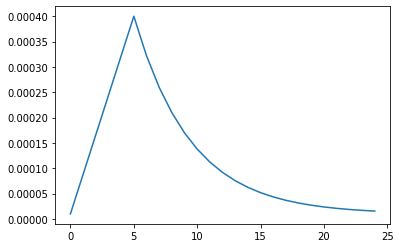

In [26]:
if strategy.num_replicas_in_sync == 8:
    start_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    min_lr = 0.00001
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1:
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: 
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8
    
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
    
import os
def get_callbacks(model_name):
    if not os.path.exists(str(model_name)+"_callback_output"):
        os.mkdir(str(model_name)+"_callback_output")

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
    #tqdm_callback = tfa.callbacks.TQDMProgressBar()
    checkpoint = tf.keras.callbacks.ModelCheckpoint(str(model_name)+"_callback_output" + '/best.h5', 
                              monitor = 'val_loss', 
                              verbose = True, save_best_only=True, 
                              mode = 'min',
                              save_weights_only = True)
    csv_logger = tf.keras.callbacks.CSVLogger(str(model_name)+"_callback_output" + '/log.csv')
    early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2,verbose=True)
    return [lr_callback, checkpoint, early, csv_logger]

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

#### Training

In [27]:
def train_cross_validate(folds, model_name):
    histories = []
    models = []
    #model_name = 'efn-b7'
    kfold = KFold(folds, shuffle = True, random_state = SEED)
    for f, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
    
        print(); print('#'*30); print('### FOLD',f+1); print('#'*30)
        
        train_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[trn_ind]['TRAINING_FILENAMES']), labeled = True)
        val_dataset = load_dataset(list(pd.DataFrame({'TRAINING_FILENAMES': TRAINING_FILENAMES}).loc[val_ind]['TRAINING_FILENAMES']), labeled = True, ordered = True)
        
        with strategy.scope():
            model = get_model(model_name)
            callbacks = get_callbacks(model_name)
        
        history = model.fit(
            get_training_dataset(train_dataset), 
            steps_per_epoch = STEPS_PER_EPOCH,
            epochs = EPOCHS,
            callbacks = callbacks,
            validation_data = get_validation_dataset(val_dataset),
            verbose=True
        )
        
        models.append(model)
        histories.append(history)
        
        tf.compat.v1.reset_default_graph()
        del model
        gc.collect()
        
        if FIRST_FOLD_ONLY: break
        
    return histories, models


#### Prediction

In [28]:
def train_and_predict(folds, model_name):
    
    test_ds = get_test_dataset(ordered=True) 
    test_images_ds = test_ds.map(lambda image, idnum: image)
    print('Start training %i folds'%folds)
    histories, models = train_cross_validate(folds, model_name)
    
    print('Computing predictions...')
    if FIRST_FOLD_ONLY: probabilities = np.average([models[i].predict(test_images_ds) for i in range(1)], axis = 0)
    else: probabilities = np.average([models[i].predict(test_images_ds) for i in range(folds)], axis = 0)
    
    predictions = np.argmax(probabilities, axis=-1)
    print('Generating submission.csv file...')
    
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
    probs_df = pd.DataFrame(probabilities)
    probs_df['ID'] = test_ids
    probs_df.to_csv('probs.csv',index=False)    
    return histories, models

In [29]:
# run train and predict
model_name = 'efn-b7'
histories, models = train_and_predict(folds = FOLDS, model_name=model_name)

Start training 2 folds

##############################
### FOLD 1
##############################
258072576/258068648 [==============================] - 8s 0us/step
Train for 85 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
84/85 [============================>.] - ETA: 4s - loss: 4.6231 - categorical_accuracy: 0.0244 - f1_score: 0.0055
Epoch 00001: val_loss improved from inf to 4.62048, saving model to efn-b7_callback_output/best.h5
85/85 [==============================] - 441s 5s/step - loss: 4.6226 - categorical_accuracy: 0.0246 - f1_score: 0.0055 - val_loss: 4.6205 - val_categorical_accuracy: 0.0264 - val_f1_score: 0.0098

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/25
84/85 [============================>.] - ETA: 0s - loss: 3.9965 - categorical_accuracy: 0.1838 - f1_score: 0.0215
Epoch 00002: val_loss improved from 4.62048 to 3.09757, saving model to efn-b7_callback_output/best.h5
85/85 [======================